In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # convert pictures to Arrays
import pandas as pd
import zipfile
import os
import sys
from wordcloud import WordCloud, STOPWORDS
import warnings
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from PIL import Image 
from scipy.interpolate import griddata
from PIL import Image

warnings.filterwarnings('ignore')


## Word cloud for all Indian states and for whole India dataset for YouTube videos 'Title' 'Description' and 'Tags'

In [9]:
zip_files = ['IndianStateMapImage','IndianStateYouTubeData']

In [10]:
def clean_up():
    dir_path = os.path.dirname(os.path.abspath("__file__"))
    file = os.listdir(dir_path)
    for images in file:
        if images.endswith(".png") or images.endswith(".csv") :
            os.remove(os.path.join(dir_path, images))
clean_up()

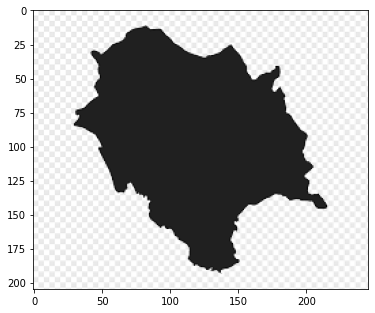

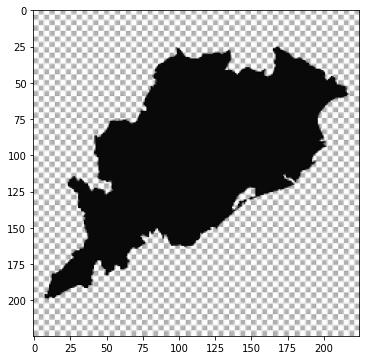

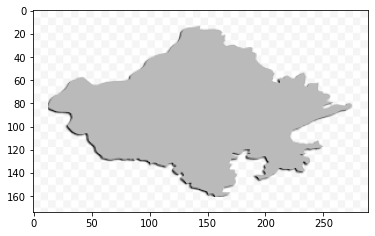

In [17]:
# For changing image resolution to get word cloud on images as mask

def make_interpolated_image(nsamples, im,X,Y):
    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = griddata((iy, ix), samples, (Y, X))
    return int_im

def change_image_resolution(low_res_img):
    for image in low_res_img:
        # Read in image and convert to greyscale array object
        img_name = image
        im = Image.open(img_name)
        im = np.array(im.convert('L'))
        
        # A meshgrid of pixel coordinates
        nx, ny = im.shape[1], im.shape[0]
        X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))
        
        # Create a figure of nrows x ncols subplots, and orient it appropriately
        # for the aspect ratio of the image.
        
        plt.figure(figsize = (6,6), facecolor = None)
        
        # Convert an integer i to coordinates in the ax array
        get_indices = lambda i: (i // nrows, i % ncols)
        
        # Sample 100, 1,000, 10,000 and 100,000 points and plot the interpolated
        # images in the figure
        nsamples = 1000000
        # axes = ax[get_indices(i)]
        plt.imshow(make_interpolated_image(nsamples,im,X,Y),
                              cmap=plt.get_cmap('Greys_r'))
        # plt.set_xticks([])
        # plt.set_yticks([])
        # plt.title('nsamples = {0:d}'.format(nsamples))
        filestem = os.path.splitext(os.path.basename(img_name))[0]
        plt.savefig(image, dpi=300)

low_res_img = ['HimachalPradesh','Odisha','Rajasthan']


low_res_img = [r'C:\\Users\\vgarg\\Downloads\\3IndianSatesYouTubeData\\' + image +'.png' for image in low_res_img]

## uncomment below when need high resolutiion image
change_image_resolution(low_res_img) 

In [5]:
## get all state data file name and image file name and store 
def get_state_data(zip_files):
    des_path = os.path.dirname(os.path.abspath("__file__"))
    print(des_path)

    fileDirectory = os.path.dirname(des_path)
    parentDirectory = os.path.dirname(fileDirectory)
    #Navigate to Strings directory
    source_path = os.path.join(parentDirectory, 'data', 'raw')
    
    for zip_file in zip_files:      
        with zipfile.ZipFile(source_path+'\\'+zip_file+'.zip',"r") as zip_ref:
            zip_ref.extractall(des_path)
    states=os.listdir(des_path)
    for state in states[:]:
        if not(state.endswith(".png")):
            states.remove(state)
    states = [state.strip('.png') for state in states]
    image_files = []
    data_files = []
    for state in states:
        image_files.append(des_path+'\\'+state+'.png')
        data_files.append(des_path+'\\'+'youTubeSearchList'+state+'.csv')
    return image_files, data_files, states  

In [223]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("","",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
    
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=5):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def tfidf(filename, image):
    df = pd.read_csv(filename,index_col=[0])
    print("Data Read")
    df['title'] = df['title'].convert_dtypes()
    df['description'] = df['description'].convert_dtypes()
    df['tags'] = df['tags'].convert_dtypes()
    df = df.dropna()
    df = df.reset_index(drop=True)
    print("Null values dropped")
    df['text'] = df['title'] + df['description'] + df['tags']

    df = df[:10] ## TO BE DELETE, just for POC coding

    df['text'] = df['text'].apply(lambda x:pre_process(x))
    
    des_path = os.path.dirname(os.path.abspath("__file__"))
    fileDirectory = os.path.dirname(des_path)
    parentDirectory = os.path.dirname(fileDirectory)
    #Navigate to Strings directory
    source_path = os.path.join(parentDirectory, 'notebook','Preprocessing', 'resources')
    source_path = source_path+ '\\stopwords.txt'
    #load a set of stop words
    stopwords=get_stop_words(source_path)

    #get the text column 
    docs=df['text'].tolist()

    #create a vocabulary of words, 
    #ignore words that appear in 85% of documents, 
    #eliminate stop words
    cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
    word_count_vector=cv.fit_transform(docs)
#     print(list(cv.vocabulary_.keys())[:10])
    
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    # you only needs to do this once, this is a mapping of index to 
    feature_names=cv.get_feature_names()
    i = 0
    tex_list = df['text'].tolist()
    tf_idf_vector_list = []
    for i in range(len(tex_list)):
        tf_idf_vector=tfidf_transformer.transform(cv.transform([tex_list[i]]))
        i = i+1
        tf_idf_vector_list.append(tf_idf_vector)
    print("Tf-idf Generated")
    
    sorted_items_list=[]
    i=0
    for i in range(len(tf_idf_vector_list)):
        sorted_items=sort_coo(tf_idf_vector_list[i].tocoo())
        i = i+1
        sorted_items_list.append(sorted_items)
    print("Sorting Complete")
    keyword_list = []
    i=0
    for i in range(len(sorted_items_list)):
        keywords=extract_topn_from_vector(feature_names,sorted_items_list[i],5)
        i = i+1
        keyword_list.append(keywords)
    print("Top 5 extraction done")
    count_list = []
    comment_words=''
    for i  in range(len(keyword_list)):
        for k in keyword_list[i]:
            count_list.append(k)
#             if((i%10000)==0):
#                 print("Keywords added",i)
            comment_words += "".join(k)+" "
    print("Keywords text file create")
    
    mask = np.array(Image.open(image))# Path for Image of the state
    
    wordcloud = WordCloud(width = 2000, height = 1600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 5,
                mask = mask,
                collocations=False).generate(comment_words)
    return wordcloud
#     plot the WordCloud image                      
#     plt.figure(figsize = (8, 8), facecolor = None)
#     plt.imshow(wordcloud)
#     plt.axis("off")
#     plt.tight_layout(pad = 0)

#     plt.imshow(wordcloud, interpolation='bilinear')

In [226]:
image_files,data_files, states = get_state_data(zip_files)

C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda


In [227]:
states_wordcloud = []
for image_file, data_file in zip(image_files,data_files):
    print('Data: ', data_file)
    print('Image: ', image_file)
    states_wordcloud.append(tfidf(data_file,image_file))
print("Total No of state for world cloud:-",len(states_wordcloud))

Data:  C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\youTubeSearchListAndhraPradesh.csv
Image:  C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\AndhraPradesh.png
Data Read
Null values dropped
Tf-idf Generated
Sorting Complete
Top 5 extraction done
Keywords text file create
Data:  C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\youTubeSearchListArunachalPradesh.csv
Image:  C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\ArunachalPradesh.png
Data Read
Null values dropped
Tf-idf Generated
Sorting Complete
Top 5 extraction done
Keywords text file create
Data:  C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\youTubeSearchListAssam.csv
Image:  C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\Assam.png
Data Read
Null values dropped
Tf-idf Generated
Sorting Complete
Top 5 extraction done
Keywords text file create
Data:  C:\Users\vgarg\Docu

Null values dropped
Tf-idf Generated
Sorting Complete
Top 5 extraction done
Keywords text file create
Data:  C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\youTubeSearchListUttarPradesh.csv
Image:  C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\UttarPradesh.png
Data Read
Null values dropped
Tf-idf Generated
Sorting Complete
Top 5 extraction done
Keywords text file create
Data:  C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\youTubeSearchListWestBengal.csv
Image:  C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\WestBengal.png
Data Read
Null values dropped
Tf-idf Generated
Sorting Complete
Top 5 extraction done
Keywords text file create
Total No of state for world cloud:- 28


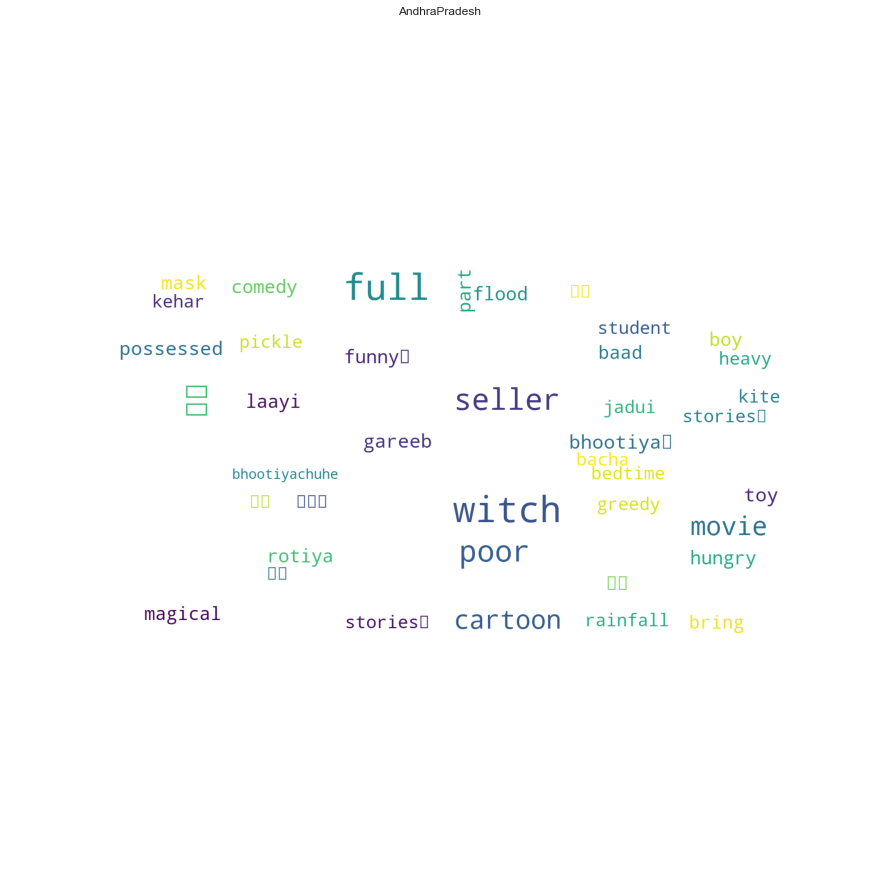

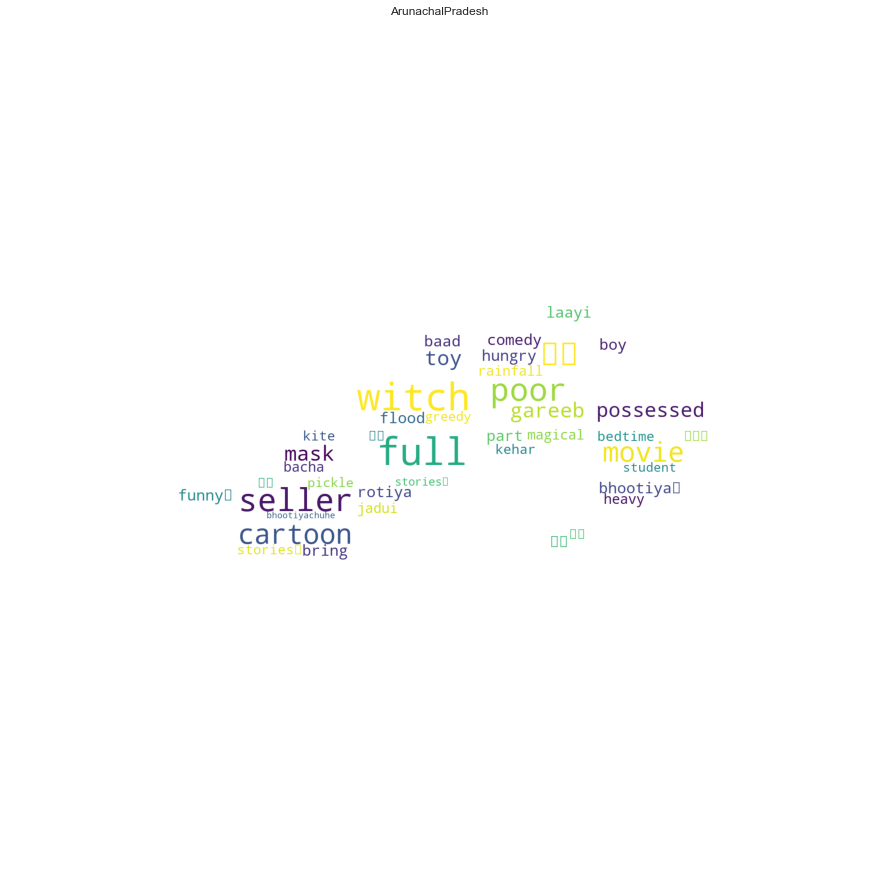

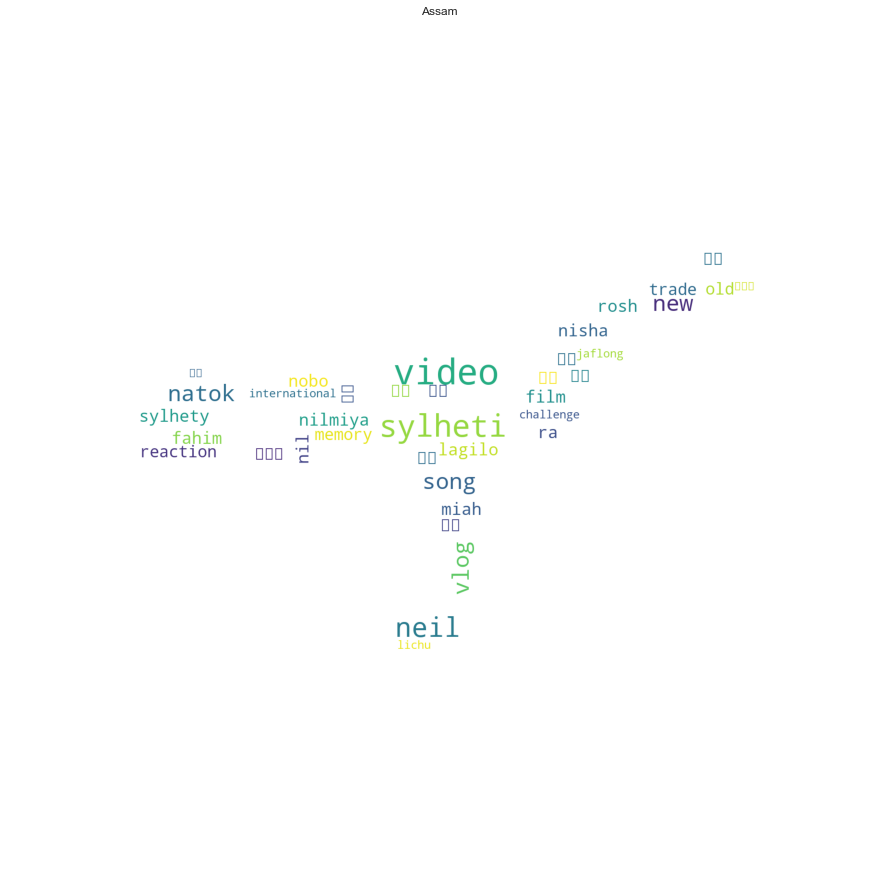

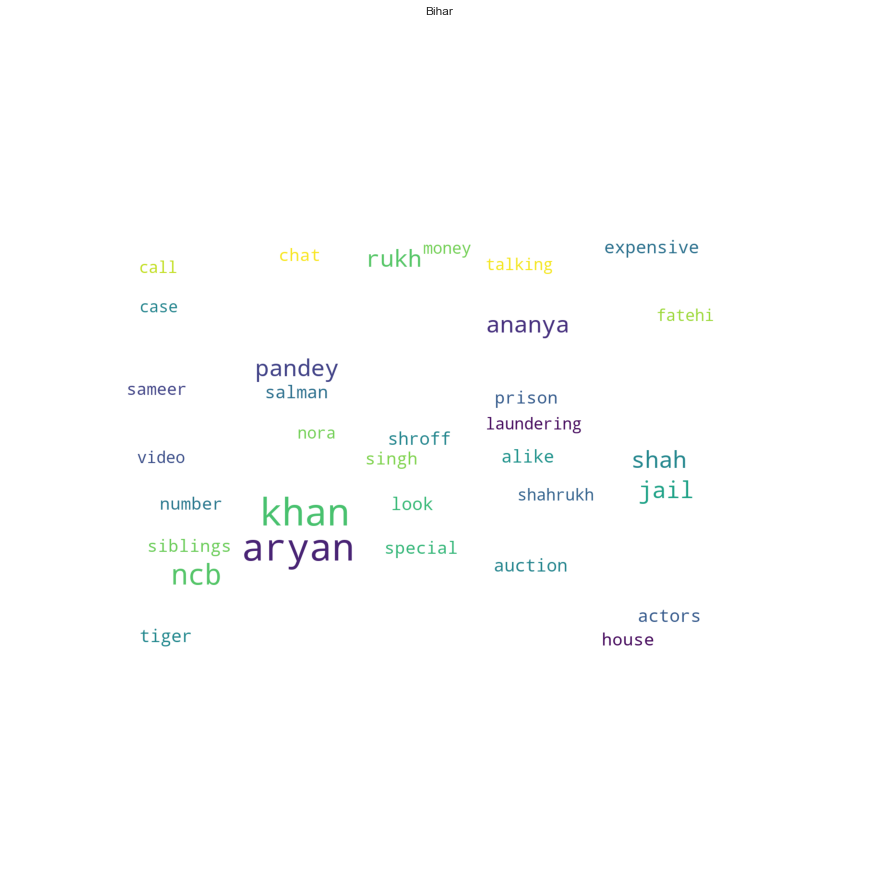

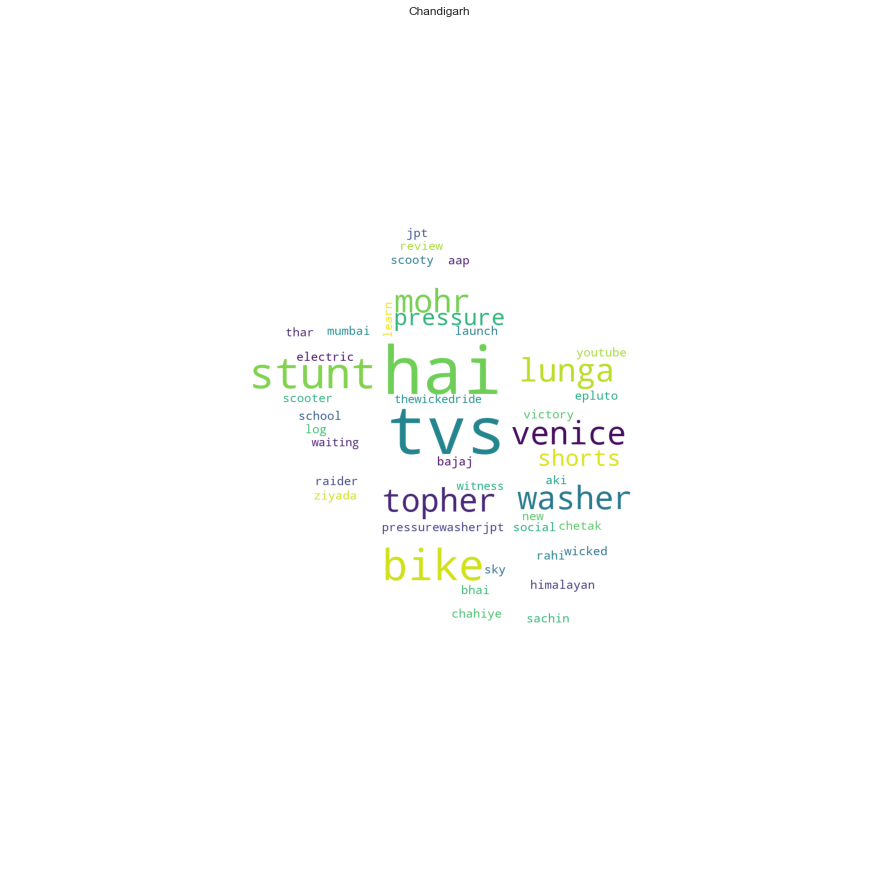

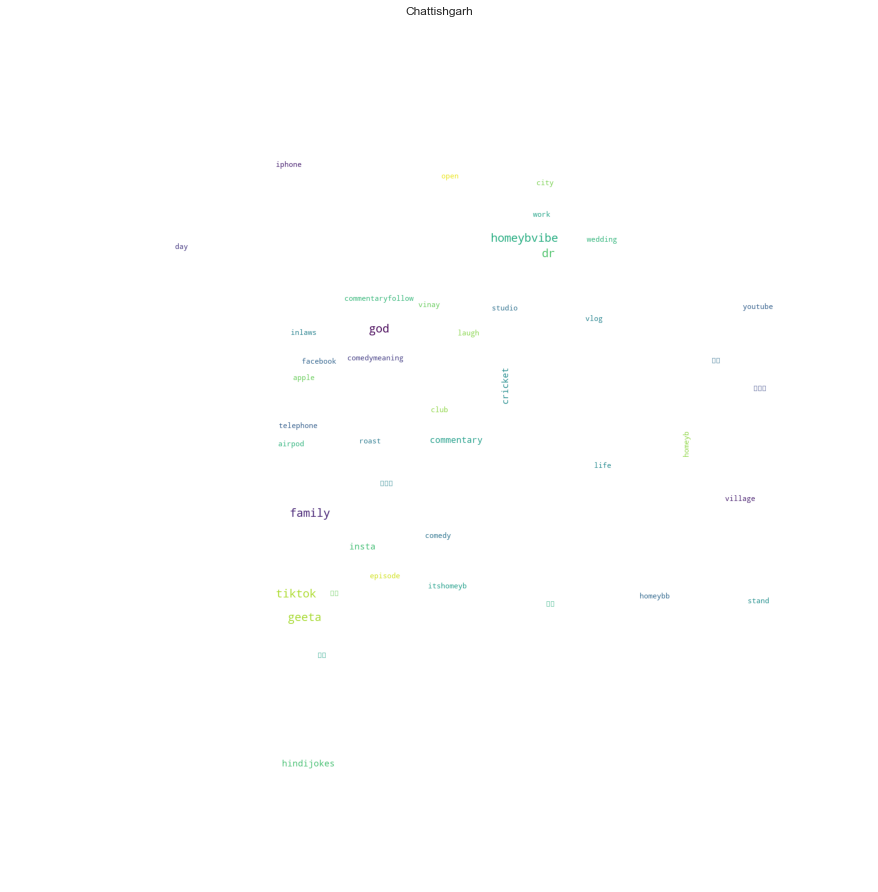

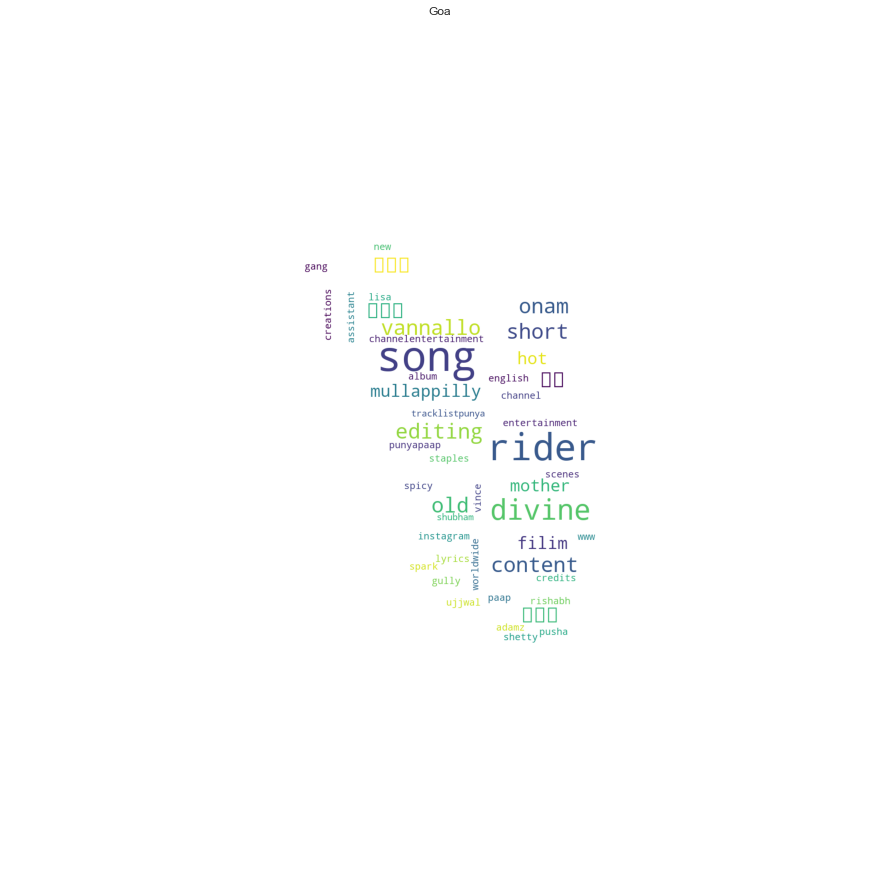

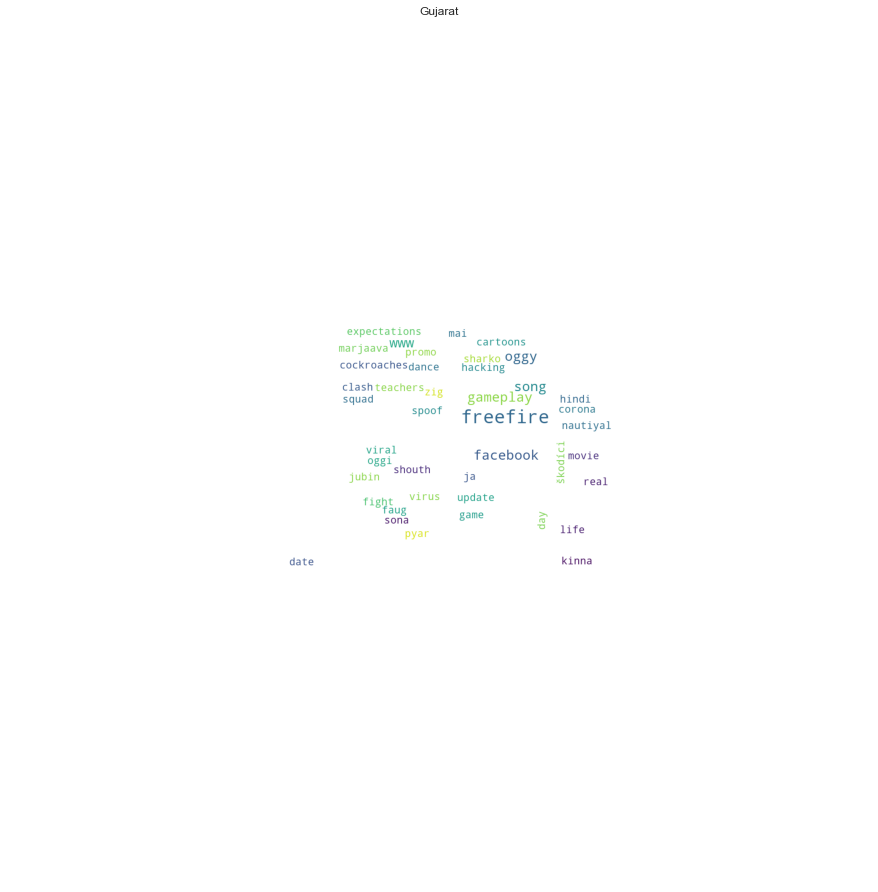

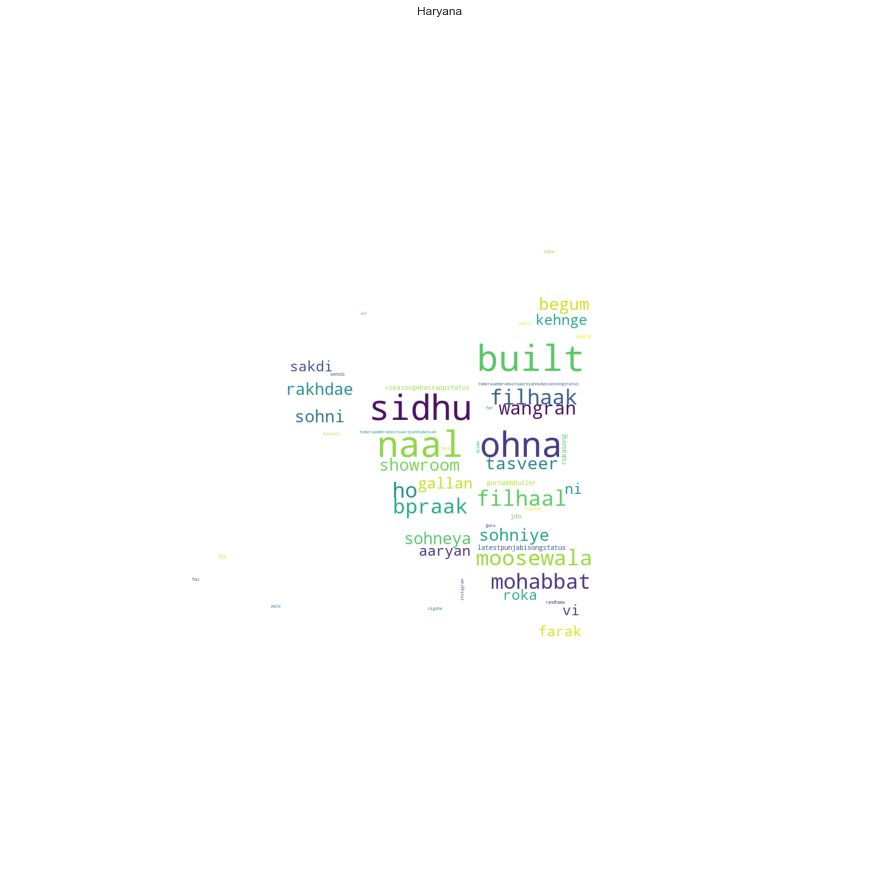

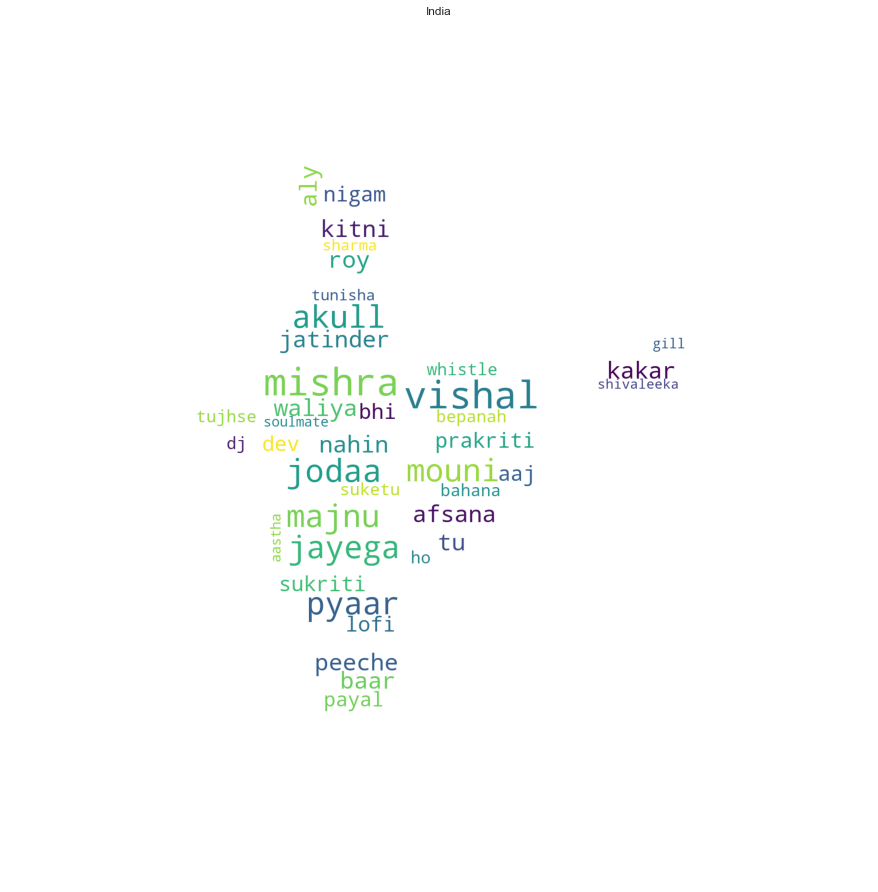

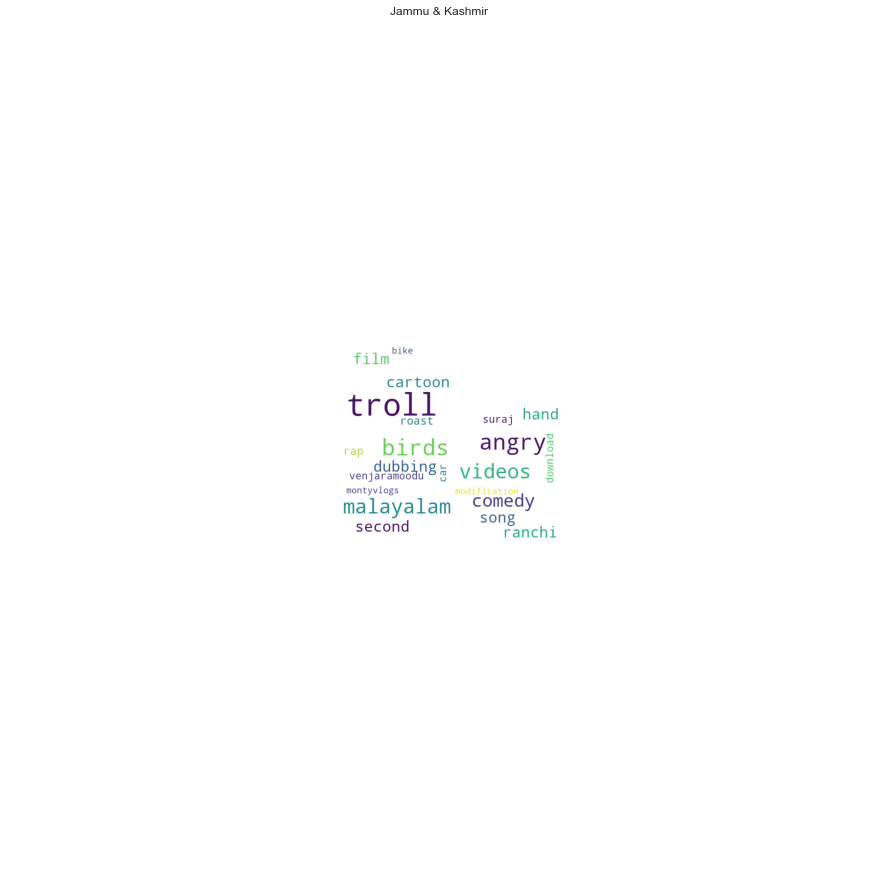

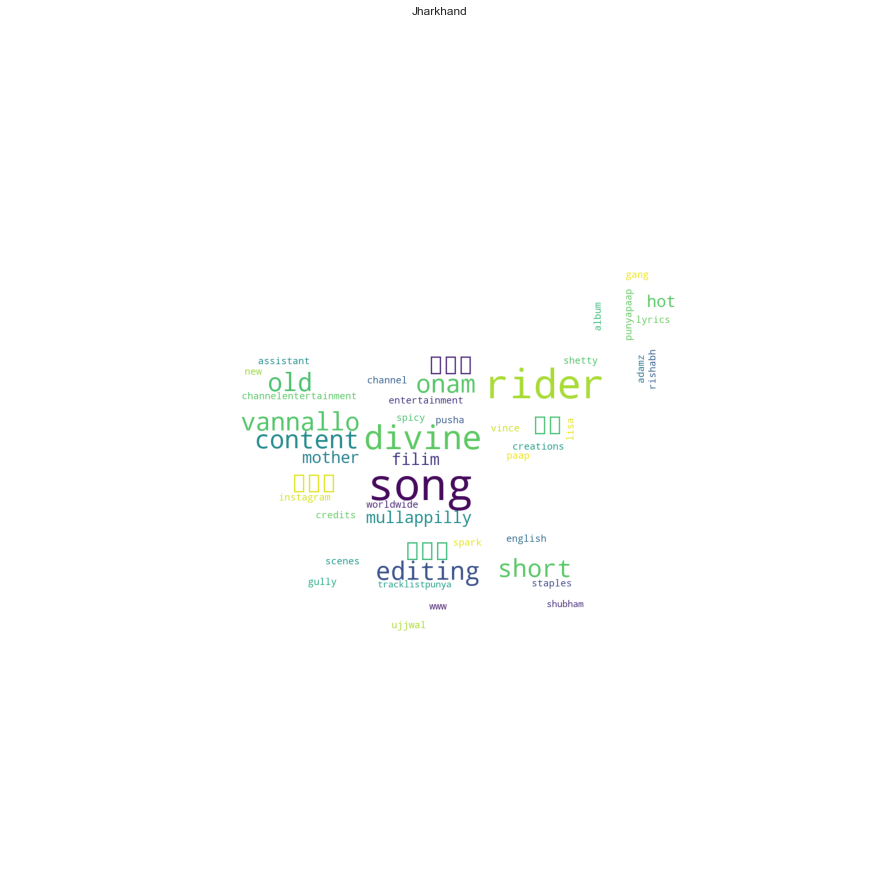

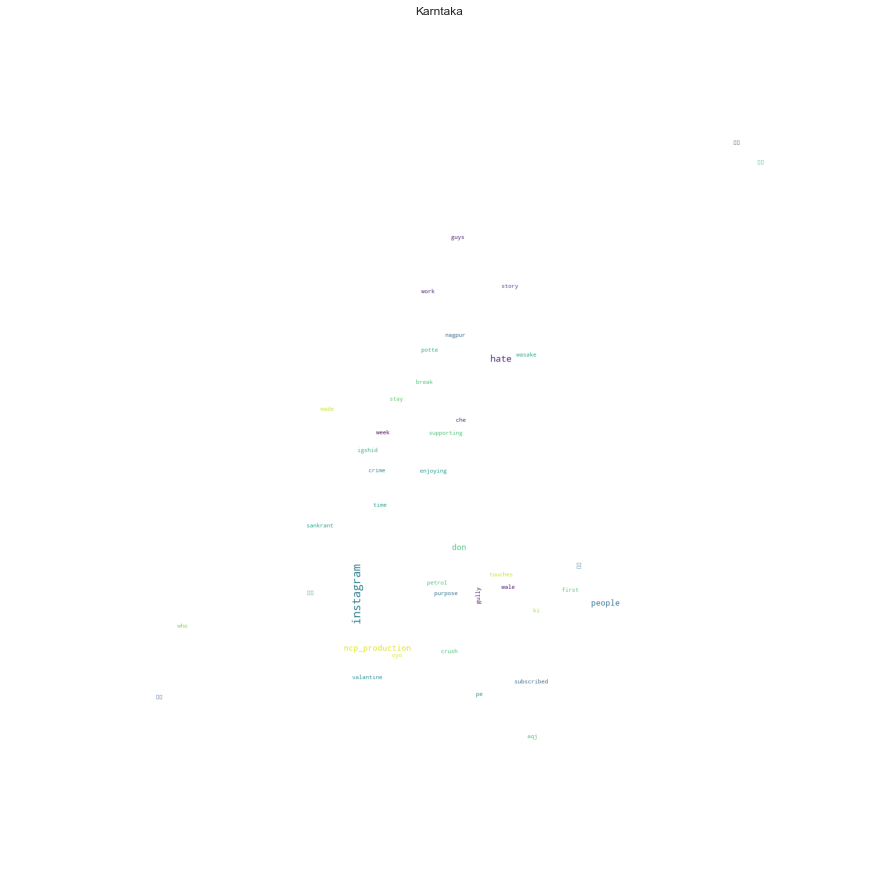

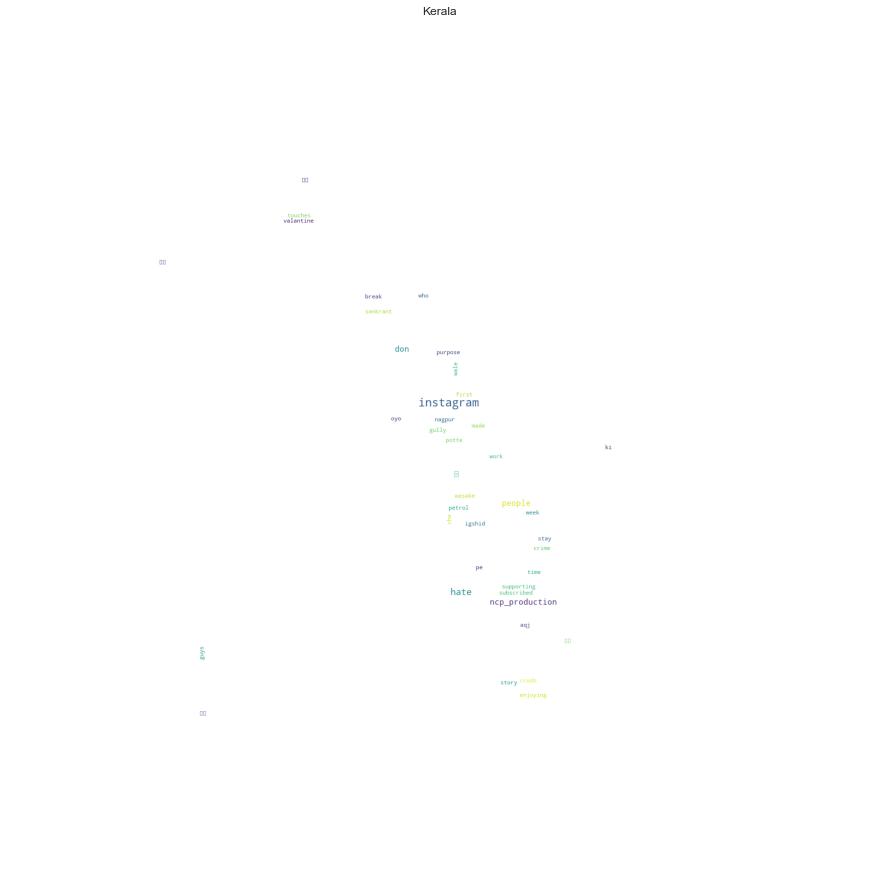

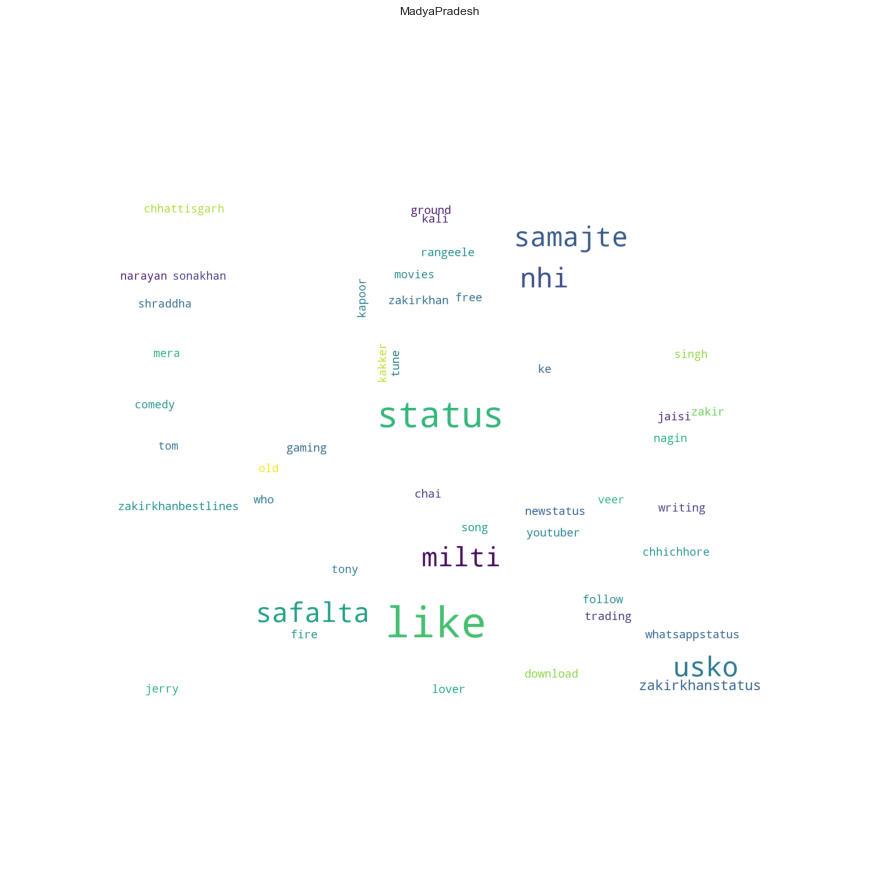

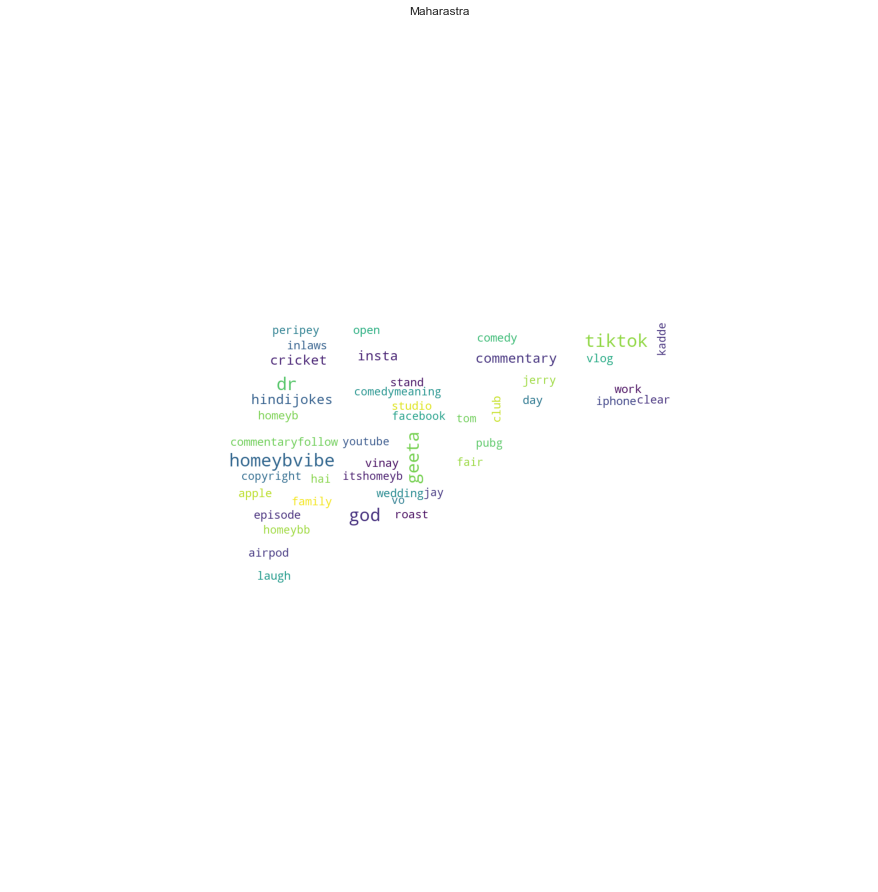

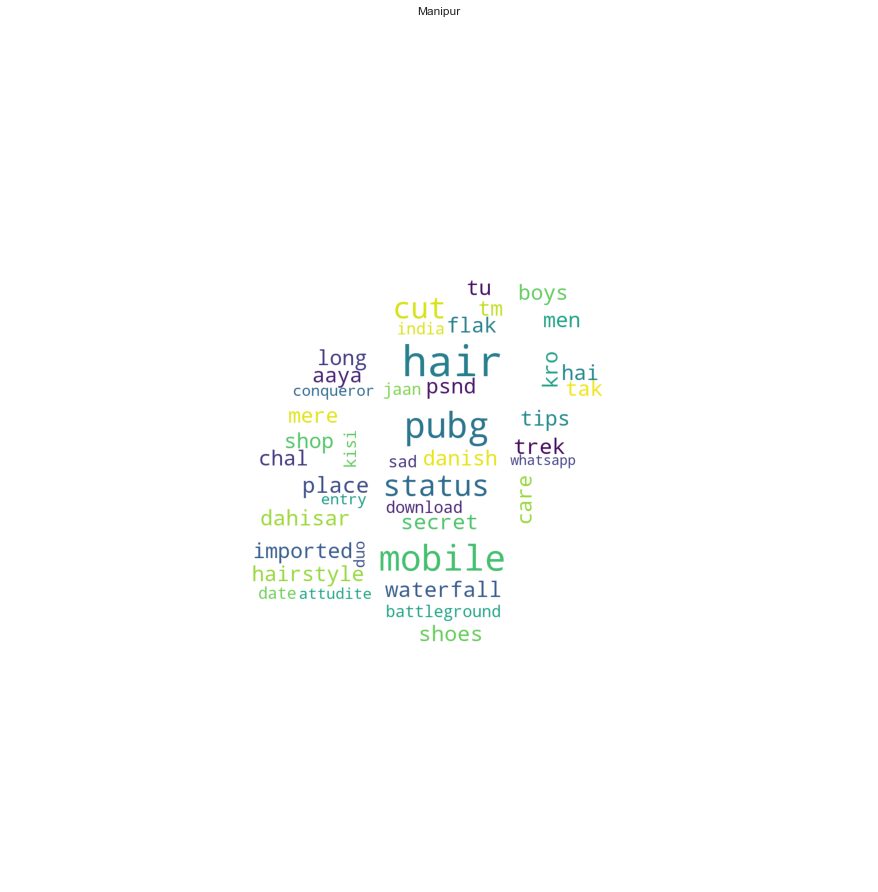

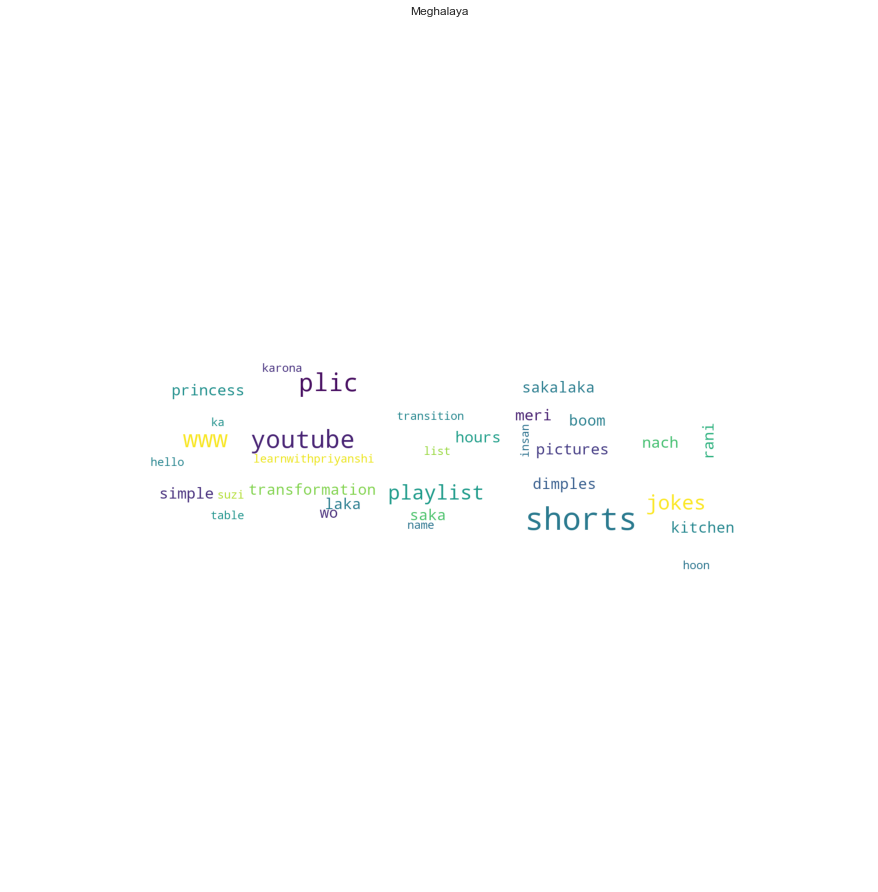

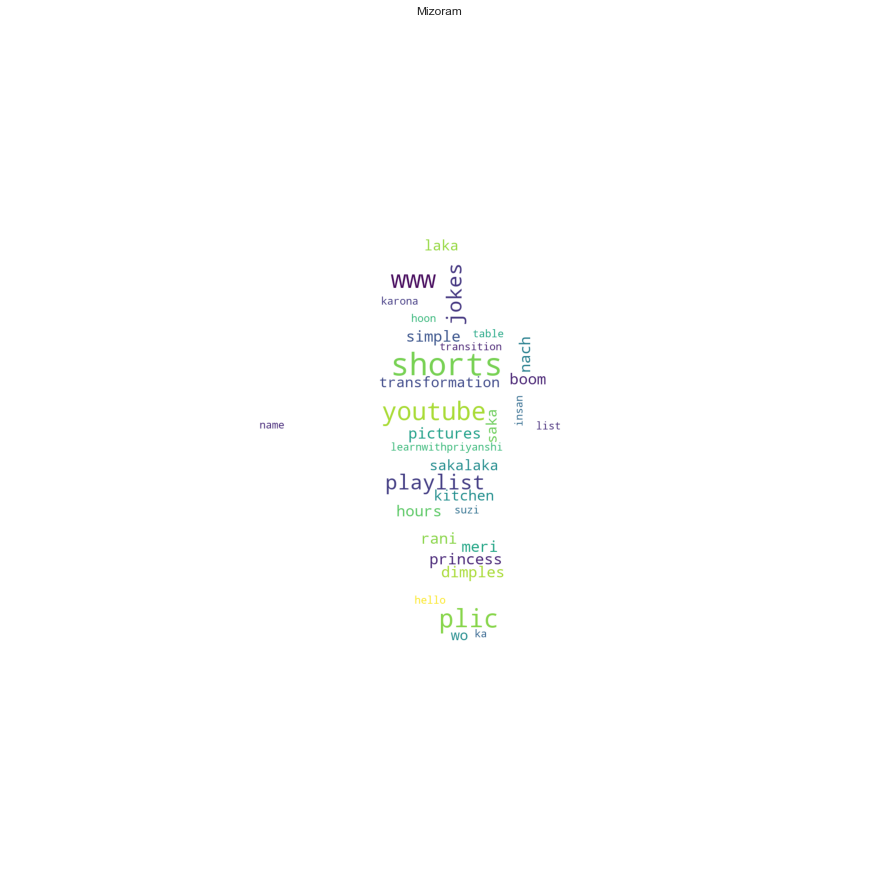

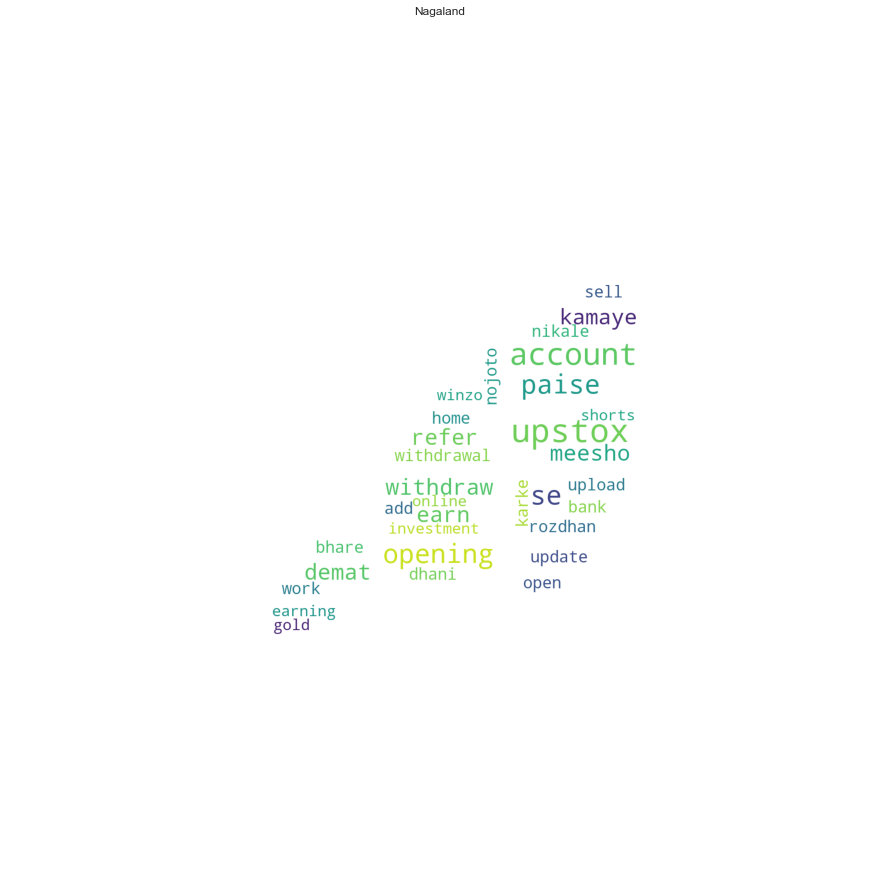

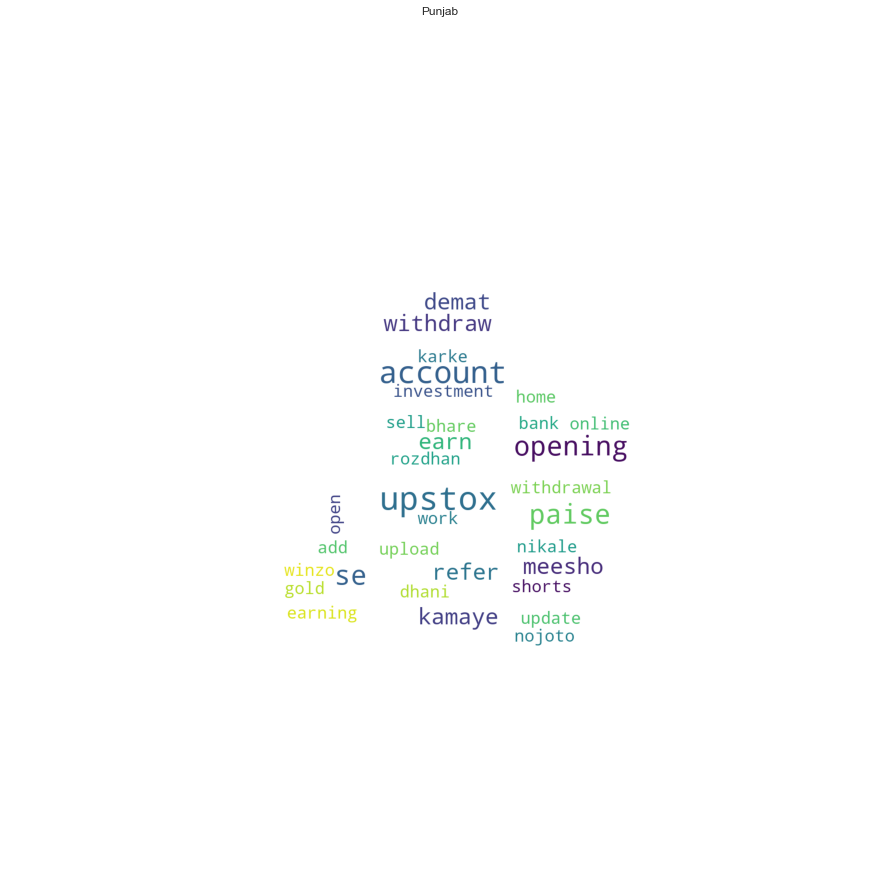

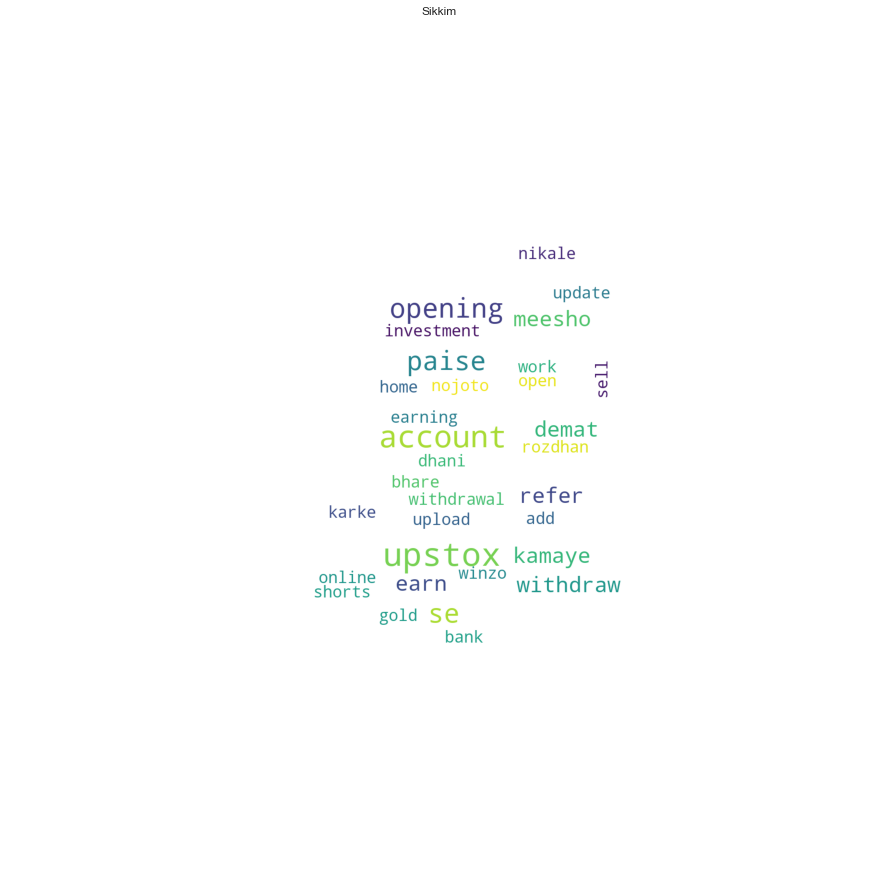

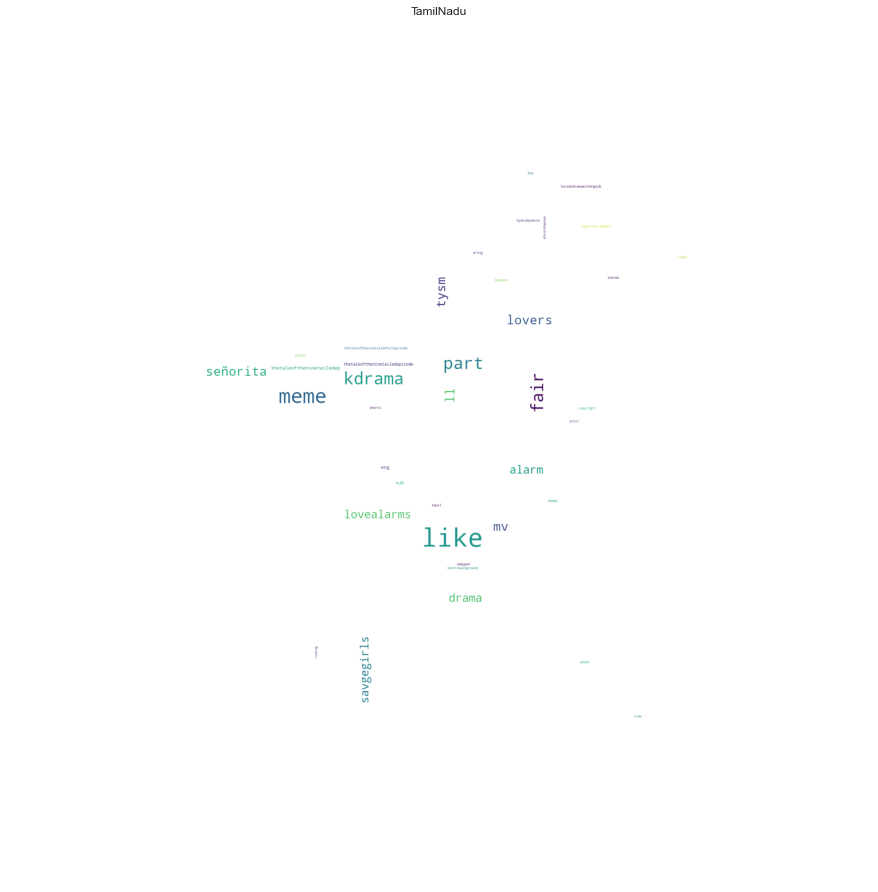

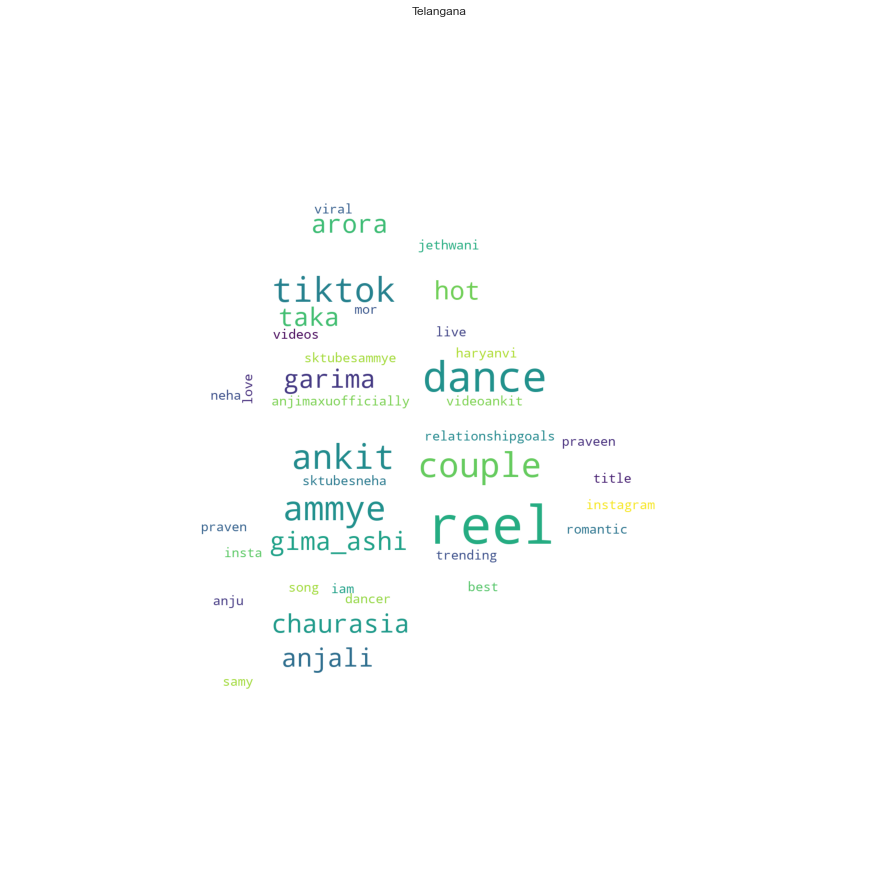

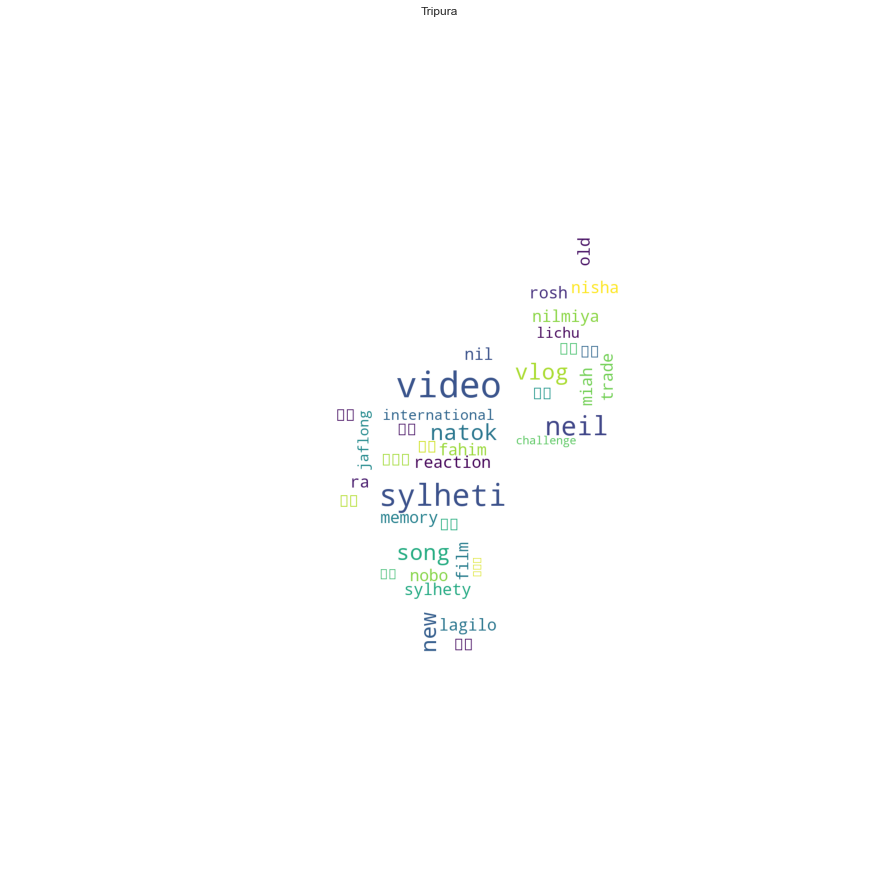

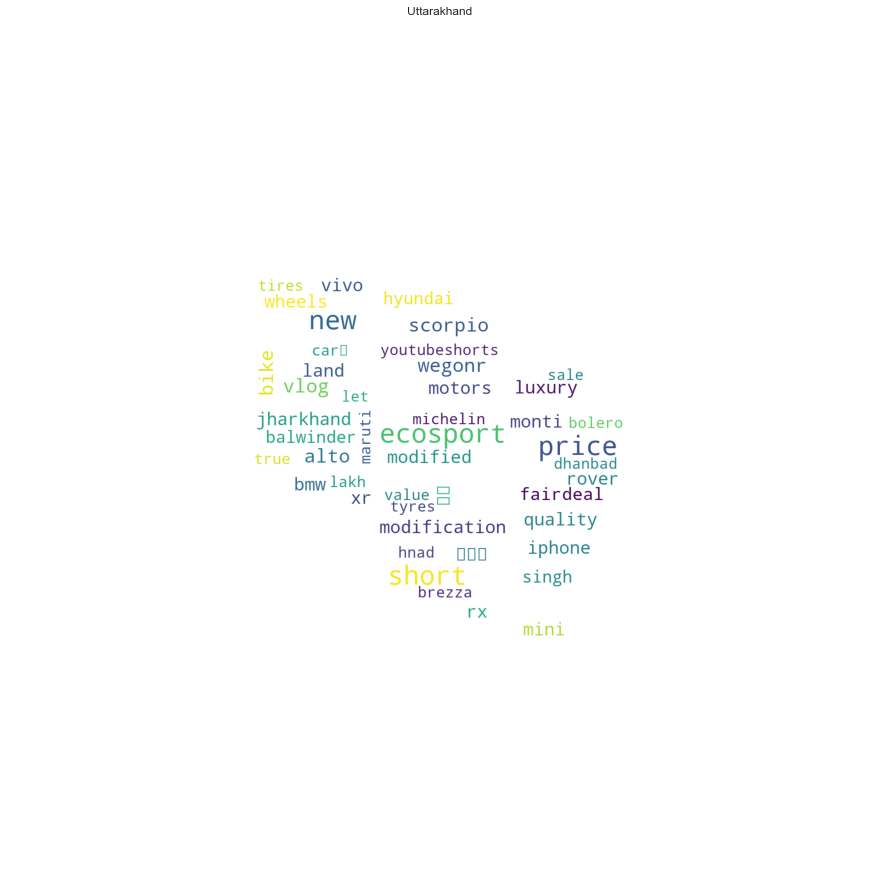

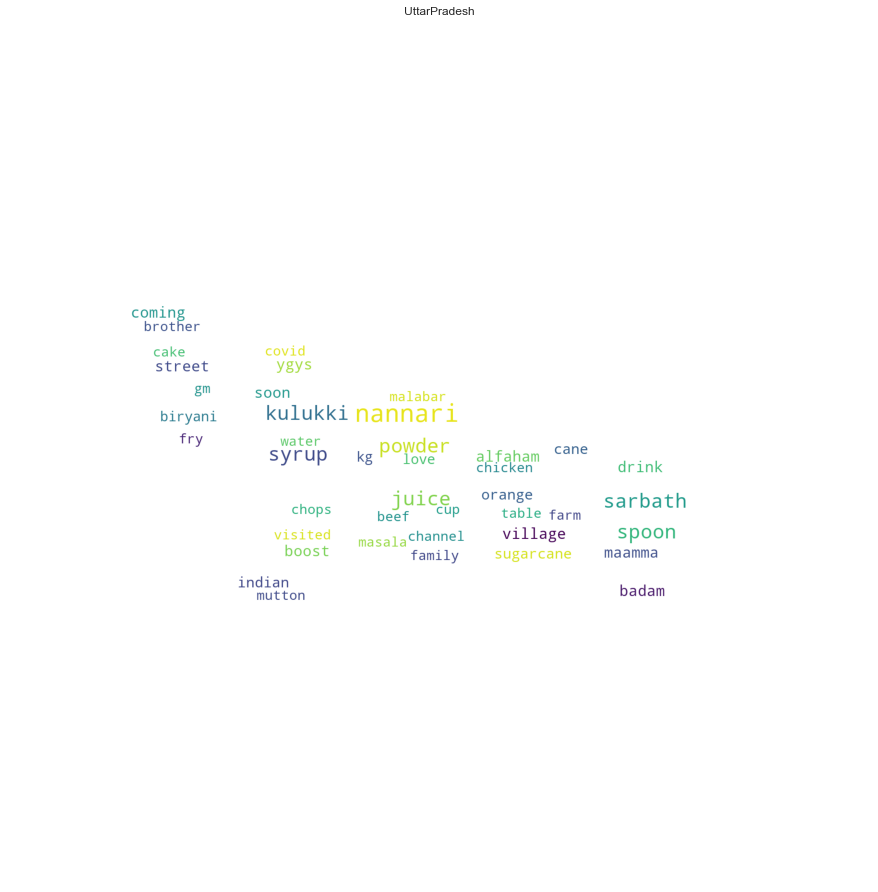

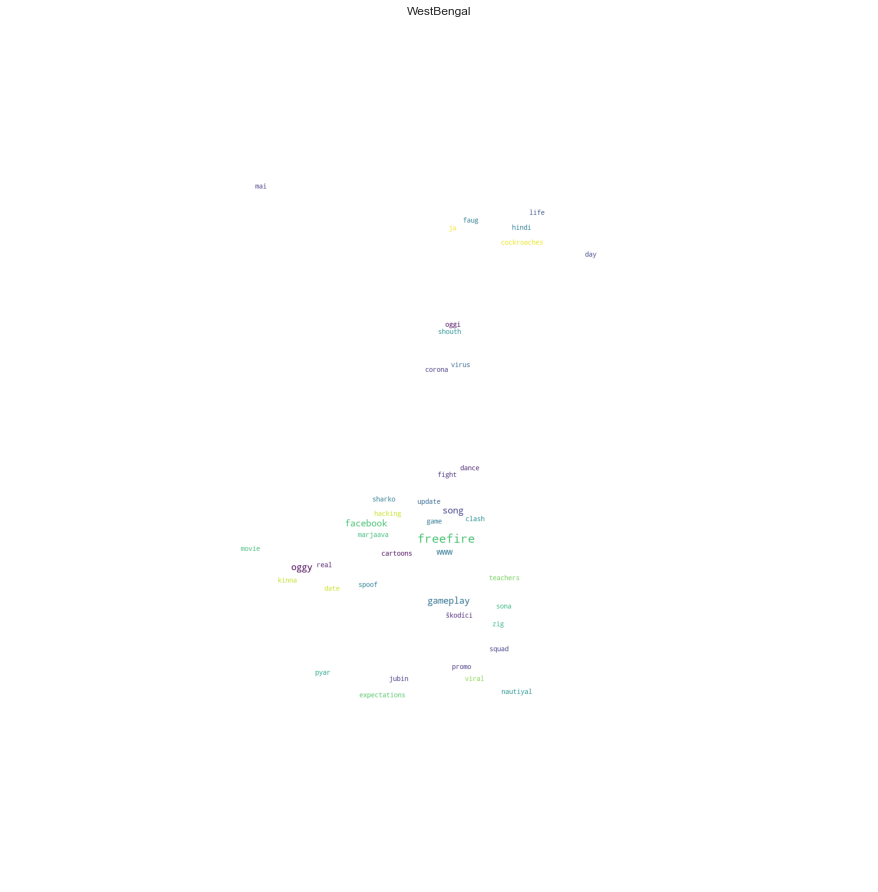

In [228]:
# plot the WordCloud image    
for state_wordcloud, state in zip(states_wordcloud, states):
    plt.figure(figsize = (12,12), facecolor = None)
    plt.imshow(state_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(state)
    plt.savefig(state+'_wordcloud.png', format = 'png', dpi=300)
    plt.show()
# plt.imshow(states_wordcloud[1, interpolation='bilinear')

In [72]:
# tfidf(filename,image)

In [73]:
# Just try two things to improve ths try to get high res images of states and have increase the wordcounts

In [ ]:
#No we need o have different paths for different images of the stated and then we can call them for a specific action

In [ ]:
# The bottom part is not needed anymore

## Wordcloud based on top liked and disliked count for youtTube india data

In [ ]:

# word count
i = 0
for i in range(2):
    if i == 0:
        df_eda.sort_values(['likeCount'], ascending=False,axis=0,inplace=True)
    else:
        df_eda.sort_values(['dislikeCount'], ascending=False,axis=0,inplace=True)
    
    comment_words = ''
    stopwords = set(STOPWORDS)
    
    # iterate through the csv file
    for val in df.description.iloc[0:10000]:
         
        # typecaste each val to string
        val = str(val)
     
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
         
        comment_words += " ".join(tokens)+" "
     
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
     
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title('Top Liked/Disliked Description')
         
plt.show()